In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Entropy
To understand the loss functions typically used in classification problems, it helps to have an understanding of entropy. First, let's look at a standard normal distribution.

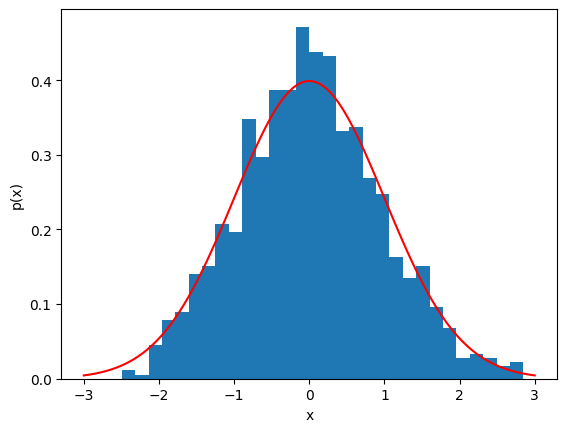

In [2]:
def N(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-(x**2) / 2)


x_s = np.random.randn(1000)
plt.hist(x_s, density=True, bins=30)
x = np.linspace(-3, 3, 100)
dx = x[1] - x[0]
plt.plot(x, N(x), "r")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.savefig("../figures/05-standard_normal_distribution.png")

The summary statistics for a standard normal distribution are, by definition, $\mathbb{E}[x] = \mu = 0$ and $\mathbb{E}[x^2] - \mathbb{E}[x] = \sigma^2 = 1$. Let's double check our data:

In [3]:
def E_N(x, f):
    # normal distribution is continuous so we need to multiply by dx to "integrate"
    dx = x[1] - x[0]
    return N(x) @ f(x) * dx


# Expected value for f(x) = x
print(E_N(x, lambda x: x))

# Expected value for f(x) = x^2
print(E_N(x, lambda x: x**2))

# Close enough

3.889985976432837e-18
0.9730695162165752


For each sample in the dataset, we can plot the **information** $I(x) = -log_2(p(x))$, which shows that less likely samples (those that are more "surprising") contain more information.

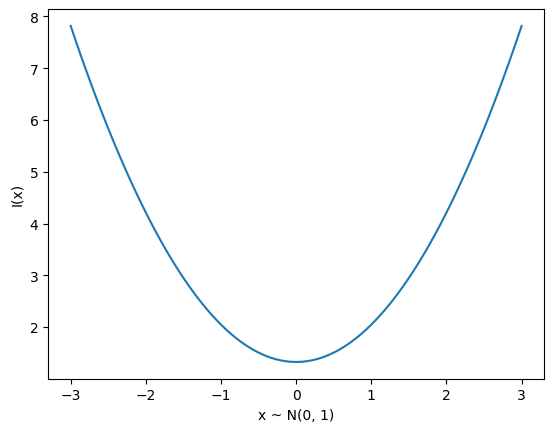

In [4]:
# Information
plt.plot(x, -np.log2(N(x)))
plt.xlabel("x ~ N(0, 1)")
plt.ylabel("I(x)")
plt.savefig("../figures/05-standard_normal_information.png")

And finally, the entropy is the expected value of the information:

$$\mathbb{E}[I(x)] = -\int_{-\infty}^{\infty}p(x)log_2(p(x))dx$$

In [5]:
print(-(N(x) @ np.log2(N(x))).sum() * dx)
# equation from https://en.wikipedia.org/wiki/Normal_distribution
print(0.5 * np.log2(2 * np.pi * np.e))

2.024435403161225
2.047095585180641


## Entropy for Bernoulli random variables
Binary classification problems are typically modelled as Bernoulli random variables, with a $p$ chance of 1 or `True` and a $(1-p)$ chance of 0 or `False`. This makes computing the entropy quite a bit simpler.

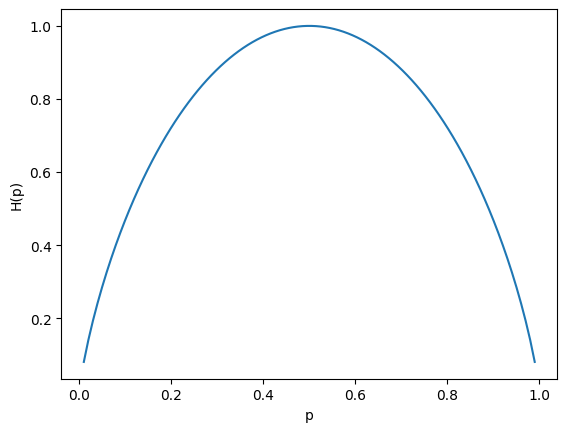

In [6]:
# Bernoulli entropy as a function of p
p = np.linspace(0.01, 0.99, 100)
plt.plot(p, -p * np.log2(p) - (1 - p) * np.log2(1 - p))
plt.xlabel("p")
plt.ylabel("H(p)")
plt.savefig("../figures/05-bernoulli_entropy.png")

Now, we can combine it all together to look at the **cross-entropy** (or "log loss") of a true label $y$ assuming it comes from a distribution with the predicted $\hat p$. Minimizing this loss function also minimizes the Kullback-Liebler divergence, as we've dropped the term that only depends on the true (and unknown) distribution of $x$.

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ccurtis\AppData\Local\Temp\ipykernel_13100\2278293658.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mathcal{L}(y, p)$")


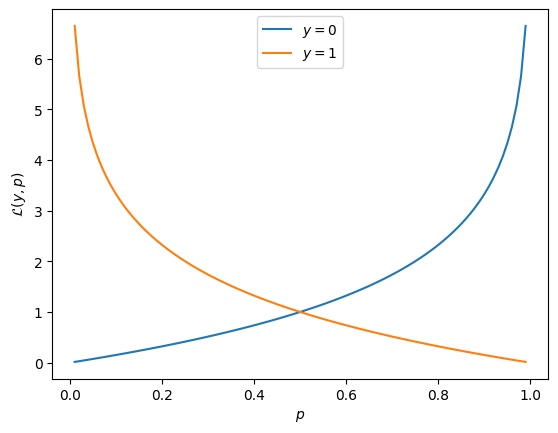

In [7]:
# Cross-entropy loss for binary classification
p = np.linspace(0.01, 0.99, 100)
y = 0
plt.plot(p, -y * np.log2(p) - (1 - y) * np.log2(1 - p), label="$y=0$")
y = 1
plt.plot(p, -y * np.log2(p) - (1 - y) * np.log2(1 - p), label="$y=1$")
plt.xlabel("$p$")
plt.ylabel("$\mathcal{L}(y, p)$")
plt.legend()
plt.savefig("../figures/05-cross_entropy_loss.png")

# Classification Exercise

This remainder of this notebook is based on the notebook from [Chapter 3](https://github.com/ageron/handson-ml3/blob/main/03_classification.ipynb) of the Scikit-learn textbook.

**Classification** is a common supervised machine learning problem where we predict a categorical label, such as whether a picture is of a cat or a potato. In this notebook, we'll look at the classic MNIST dataset, which is technically an image classification problem, but the images are so tiny that we can treat each pixel as a feature.

## Load and explore the data

In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False, parser="auto")
# Read some info about MNIST, including a reference to the original source.
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [9]:
# mnist is a dictionary-like object. We only really need the data and target.
X, y = mnist.data, mnist.target

# 28x28 pixels per image, 70,000 images total.
print(X.shape, y.shape)

# be careful - the labels are strings, not numbers!
y[:10]

(70000, 784) (70000,)


array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4'], dtype=object)

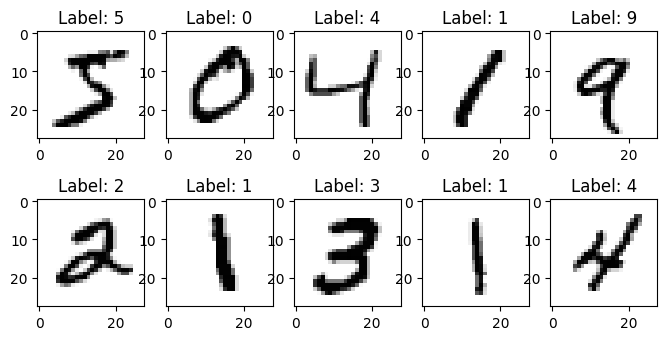

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

In [10]:
import matplotlib.pyplot as plt

# plot a few images and their labels
# looks like numbers!
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap="gray_r")
    ax.set(title=f"Label: {y[i]}")
plt.show()

print(X[0].flatten())

Text(0, 0.5, 'Count')

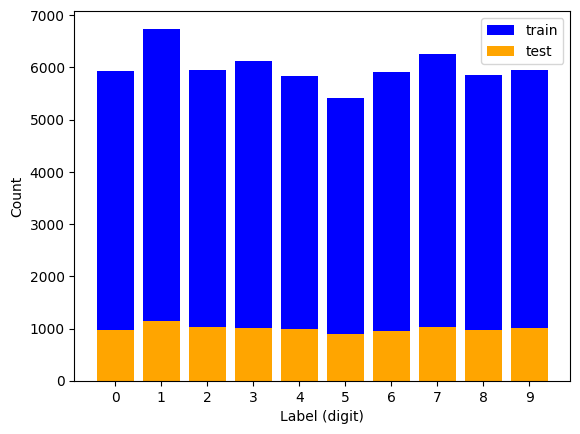

In [11]:
# split into train and test sets - 60,000 for training, 10,000 for testing
# Note: we could use train_test_split here, but we'll do it manually because that's what the book does.
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# make sure the distribution of labels in the train and test sets is similar
import numpy as np

y_train_counts = np.unique(y_train, return_counts=True)
y_test_counts = np.unique(y_test, return_counts=True)

plt.bar(y_train_counts[0], y_train_counts[1], color="blue", label="train")
plt.bar(y_test_counts[0], y_test_counts[1], color="orange", label="test")
plt.legend()
plt.xlabel("Label (digit)")
plt.ylabel("Count")

This is about as clean as a dataset gets - can you think of any preprocessing that might be useful?

## Train a model
For the regression example we spent a bunch of time on preprocessing and data exploration, but this time we'll dive in to classification as I want to get to the metrics.

The model we'll use is the [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), which implements some kind of linear classifier using stochastic gradient descent. With default parameters, it trains a support vector machine (SVM), while the "stochastic" part means that the gradient is computed on a single random sample at a time. It's fast as a result, and can be used for large datasets, but might not be the most accurate.

The SGDClassifier also includes a penalty term or regularization parameter, which imposes a penalty on the weights and helps to avoid overfitting. By default the penalty term is the L2 norm, or the sum of the squares of the weights. You can read more about the math going on [here](https://scikit-learn.org/stable/modules/sgd.html#mathematical-formulation).

We'll also start with a binary classification problem, arbitrarily choosing the digit 5. Many of the metrics we'll look at are most intuitive for binary classification.

In [12]:
# Extract a binary subset of "5 or not 5"
# True for all 5s, False for all other digits
y_train_5 = y_train == "5"
y_test_5 = y_test == "5"

# train a binary classifier
from sklearn.linear_model import SGDClassifier

# Use the defaults, but understand what that implies
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [13]:
# Choose some random samples to predict
some_digits = X_train[:10]
print(y_train_5[:10])
sgd_clf.predict(some_digits)  # looks pretty good!

[ True False False False False False False False False False]


array([ True, False, False, False, False, False, False, False, False,
       False])

From this spot check, it looks like the classifier is doing a pretty good job - there's one 5 followed by a bunch of not-5s. But how should we actually measure the performance? Like the regression task, let's try cross-validation with **accuracy** as the metric.

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Looks pretty solid! However, is accuracy the best metric in this scenario? Let's define a new classifier that just says "everything is not a 5" and see what happens.

In [19]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, sgd_clf.predict(X_train))
# Not too bad, the diagonal elements are definitely stronger than the off-diagonal.
# Still a lot of false positives though, which we expect from our mostly not-5 dataset.

array([[52316,  2263],
       [  601,  4820]])

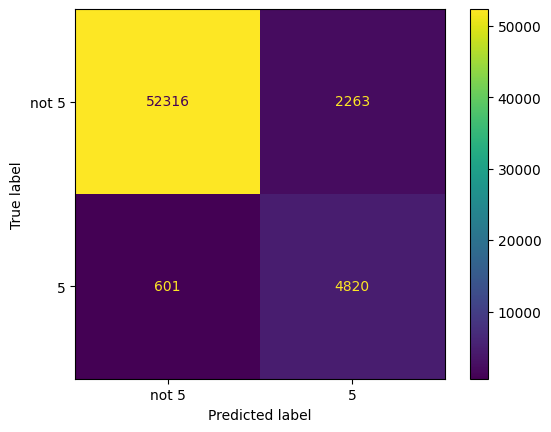

In [21]:
# we can also visualize it as a prettier heatmap
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_train_5, sgd_clf.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not 5", "5"])
disp.plot()

## Precision-Recall Tradeoff
It would be great to be able to improve both precision and recall, but usually you have to decide which is more important. Internally, the `SGDClassifier` computes a score for each instance, then applies a **threshold** to decide whether it's positive (`'5'`) or negative (`'not-5'`). We can't set the threshold parameter directly, but we can look at the scores and apply our own threshold.

In [ ]:
import numpy as np

jitter = 0.01  # add some jitter to make the plot easier to read
scores = sgd_clf.decision_function(X_train)
new_thresh = -5000
plt.scatter(y_train_5 + jitter * np.random.randn(len(y_train_5)), scores, alpha=0.1)
plt.xlabel("Label (0 = not 5, 1 = 5)")
plt.ylabel("Decision function score")
plt.plot([-0.1, 1.1], [0, 0], "k--", label="Default threshold")
plt.plot([-0.1, 1.1], [new_thresh, new_thresh], "r--", label="Higher TP threshold")
plt.legend()

With the new threshold of -5000, we're increasing the number of true positives - but we're also capturing a whole lot of false positives. This is the **precision-recall tradeoff**. If we calculate the numbers for the new threshold, we get:

In [ ]:
from sklearn.metrics import precision_score, recall_score
new_y = scores > new_thresh
print("Precision:", precision_score(y_train_5, new_y))
print("Recall:", recall_score(y_train_5, new_y))

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, scores)

# plot the ROC curve
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], "k--")
plt.grid(True)
plt.xlabel("False positive rate (1 - specificity)")
plt.ylabel("True positive rate (sensitivity)")

# label the default threshold of 0
zero_thresh_i = np.argmin(abs(thresholds))
plt.plot(fpr[zero_thresh_i], tpr[zero_thresh_i], "ro", label="Default threshold")

# And the new one at -5000
new_thresh_i = np.argmin(abs(thresholds - new_thresh))
plt.plot(fpr[new_thresh_i], tpr[new_thresh_i], "go", label="Higher TP threshold")
plt.legend()

## Area under the ROC Curve (AUC)
The ROC curve can be useful for choosing a threshold,  but it can also be used to compare different classifiers. The **area under the curve** (AUC) is a single number that summarizes the performance of the classifier. Since our plot is normalized to a range of 0-1 for both axes, a perfect classifier would have an AUC of 1, while a random guess would be 0.5. If the AUC is less than 0.5, something is very wrong, or you might want to invert the predictions.

We need another classifier to compare to, so let's add on a `RandomForestClassifier`. The next cell uses a cross-validation with $k=3$ folds, so it may take a minute or so to run.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba"
)

y_scores_forest = y_probas_forest[:, 1]
# score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [ ]:
# calculate the AUC for both classifiers
from sklearn.metrics import roc_auc_score

sgd_auc = roc_auc_score(y_train_5, scores)
forest_auc = roc_auc_score(y_train_5, y_scores_forest)

# Plot both ROC curves on the same plot
plt.plot(fpr, tpr, linewidth=2, label=f"SGD: AUC={sgd_auc:.3f}")
plt.plot(
    fpr_forest, tpr_forest, linewidth=2, label=f"Random Forest: AUC={forest_auc:.3f}"
)
plt.plot([0, 1], [0, 1], "k--")
plt.grid(True)
plt.xlabel("False positive rate (1 - specificity)")
plt.ylabel("True positive rate (sensitivity)")
plt.legend()

## Multi-class Classification
So far most of the metrics discussed are only applicable to binary classification. However, many tasks (such as the digit recognition problem) are actually **multi-class** classification problems. There are three basic strategies to handle this:
1. **One-versus-all** (OvA): Train a binary classifier for each class, then choose the class with the highest score.
2. **One-versus-one** (OvO): Train a binary classifier for each pair of classes, then choose the class that wins the most pairs.
3. Use a classifier that can handle multiple classes directly, such as a Random Forest or Naive Bayes classifier.

Let's try a Random Forest classifier on the MNIST dataset, and then look at the confusion matrix.

In [ ]:
# As usual random forests take a bit of time to train, especially with cross validation
multi_forest = RandomForestClassifier(random_state=42)
multi_forest.fit(X_train, y_train)
cv_predictions = cross_val_predict(multi_forest, X_train, y_train, cv=3)

In [ ]:
cm_forest = confusion_matrix(y_train, cv_predictions)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_forest, display_labels=multi_forest.classes_
)
disp.plot()
# Looks pretty great!

Let's look at the precision and recall for each class. These are still just binary metrics, but we can go one class at a time and calculate:

$$\mathrm{precision_{class}} = \frac{TP_{class}}{TP_{class} + FP_{class}}$$

where $TP_{class}$ is the element on the diagonal of the confusion matrix, $FP_{class}$ is the sum of the elements in the column, and $FN_{class}$ is the sum of the elements in the row. For example, the precision for class 0 is:

$$\mathrm{precision_{0}} = \frac{5840}{5840 + 1 + 27 + 7 + 12 + 20 + 26 + 4 + 9 + 21} = 0.979$$

In [ ]:
# Calculate the precision and recall for each class
multi_precision = precision_score(y_train, cv_predictions, average=None)
multi_recall = recall_score(y_train, cv_predictions, average=None)

plt.boxplot([multi_precision, multi_recall], labels=["Precision", "Recall"])
plt.ylabel("Score")
plt.ylabel("Metric")
plt.title("Average Precision and Recall across all classes")

# and the mean F1 score to summarize
from sklearn.metrics import f1_score

mean_f1 = np.mean(f1_score(y_train, cv_predictions, average=None))
print(f"Mean F1 score: {mean_f1:.3f}")

In [ ]:
# Finally, let's see how it behaves on the test set
test_predictions = multi_forest.predict(X_test)
cm_test = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_test, display_labels=multi_forest.classes_
)
disp.plot()  # still looking good!

In [ ]:
# This cell just generates a figure with fake ROC data
import numpy as np

# Define the amount of jitter
jitter = 0.02

# Generate smooth curves
fake_fpr = np.geomspace(1, 2, 100) - 1
tpr1 = fake_fpr**0.1
tpr2 = fake_fpr**0.2

# Add jitter, because it's usually not perfectly smooth
tpr1 += jitter * np.random.rand(len(tpr1)) - jitter / 2
tpr2 += jitter * np.random.rand(len(tpr2)) - jitter / 2

plt.plot(fake_fpr, tpr1, linewidth=2, label="Classifier 1")
plt.plot(fake_fpr, tpr2, linewidth=2, label="Classifier 2")
plt.plot([0, 1], [0, 1], "k--")
plt.grid(True)
plt.xlabel("False positive rate (1 - specificity)")
plt.ylabel("True positive rate (sensitivity)")
plt.legend()

plt.savefig("../figures/05-fake_roc.png")